In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

df = pd.read_csv("data/allendale-students.csv")

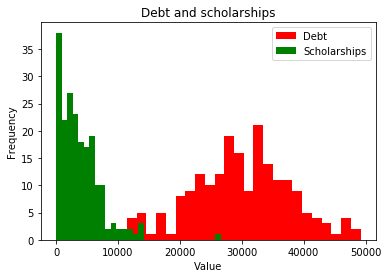

In [2]:
n_bins = 30
colors = ["red", "green"]
plt.hist(df.debt, bins=n_bins, color=colors[0])
plt.hist(df.scholarship, bins=n_bins, color=colors[1])
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title("Debt and scholarships")
labels= ["Debt","Scholarships"]
_ = plt.legend(labels)

In [3]:
df_with_dummies = pd.get_dummies(df).drop(columns=['housing_off campus', 'major_STEM']) 
df_with_dummies.columns = df_with_dummies.columns.str.replace(' ', '_')
df_with_dummies # off-campus and stem majors are reference catgories

distance  scholarship  parents  car   debt  housing_on_campus  \
0          40         1532    0.440    6  26389                  0   
1          30         7479    0.265    7  21268                  1   
2         130         2664    0.115    3  32312                  1   
3         120         1998    0.325    9  28539                  1   
4          30         1462    0.105   10  34867                  0   
..        ...          ...      ...  ...    ...                ...   
195        30         5321    0.445    8  21873                  0   
196        50         5916    0.020   10  33122                  0   
197       410         5583    0.200    7  33666                  1   
198       320         1282    0.250    4  44262                  0   
199       110         7116    0.250    5  24411                  0   

     major_business  major_other  
0                 0            0  
1                 0            0  
2                 1            0  
3                 1            0  
4                 0            1  
..              ...          ...  
195               0            0  
196               0            0  
197               1            0  
198               1            0  
199               0            0  

[200 rows x 8 columns]

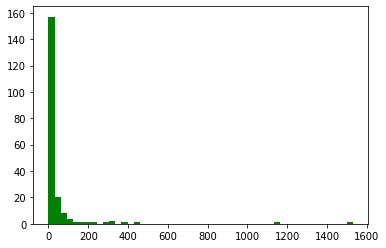

In [4]:
df['scholarship_debt'] = df['debt']/ df['scholarship']
n_bins = 50
_ = plt.hist(df['scholarship_debt'], bins=n_bins, color=colors[1])

In [5]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so[so!=1]

scholarship       debt                0.642963
debt              scholarship         0.642963
distance          debt                0.498096
debt              distance            0.498096
                  parents             0.375440
parents           debt                0.375440
scholarship       scholarship_debt    0.275512
scholarship_debt  scholarship         0.275512
                  debt                0.229879
debt              scholarship_debt    0.229879
distance          scholarship_debt    0.093353
scholarship_debt  distance            0.093353
scholarship       distance            0.078612
distance          scholarship         0.078612
                  parents             0.062568
parents           distance            0.062568
car               scholarship_debt    0.053710
scholarship_debt  car                 0.053710
                  parents             0.034507
parents           scholarship_debt    0.034507
scholarship       car                 0.031174
car          

In [6]:
predictors = df_with_dummies.drop(columns='debt')
cols = predictors.columns

## Get formula

In [7]:
formula_list = []
n_columns = len(cols) + 1
for i in range(1, n_columns):
    iters = combinations(cols, i)
    for item in iters:
        formula = "debt ~ " + " + ".join(item)
        formula_list.append(formula)

In [8]:
def count_params(model):
    params = model.replace("+", ",")
    params = params.replace("debt ~", "")
    n_params = params.count(',') + 1
    return n_params

def get_r_sq(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.rsquared_adj

def get_coefs(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.params

In [9]:
adj_r_df = pd.DataFrame({'model': formula_list, 
                         'adj_rsq': map(get_r_sq, formula_list),
                         'n_params': map(count_params, formula_list),
                         'coefs': map(get_coefs, formula_list) # we really dont want to run this twice :()
                         })

In [10]:
coefs = pd.DataFrame(adj_r_df.coefs.tolist())
model_results = pd.concat([adj_r_df.reset_index(drop=True), coefs], axis=1)
model_results = model_results.drop(columns=['coefs'])

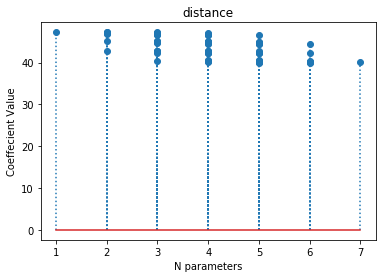

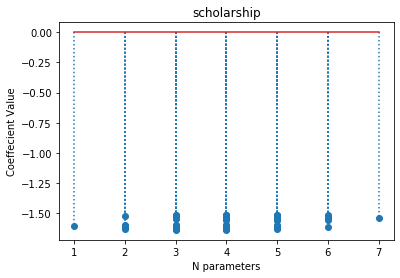

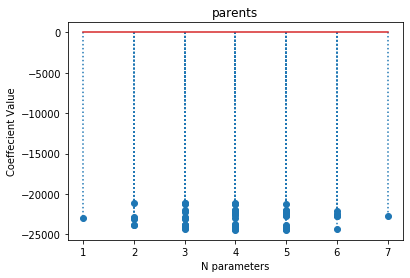

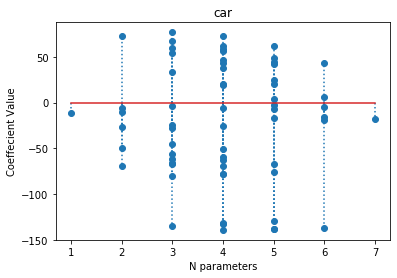

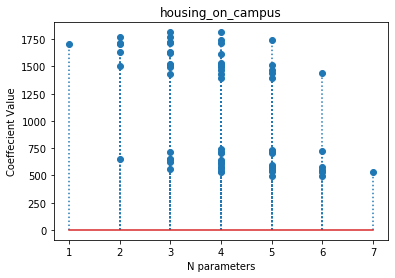

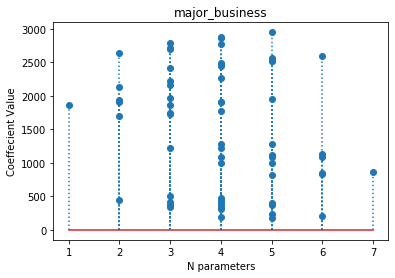

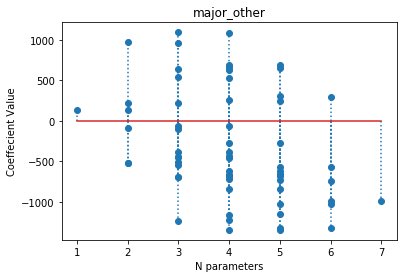

In [21]:
terms = model_results.columns[4:]
for term in terms:
    plt.stem(model_results.n_params, model_results[term], use_line_collection=True, linefmt=':')
    plt.ylabel('Coeffecient Value')
    plt.xlabel('N parameters')
    plt.title(term)
    plt.show()

In [79]:
reg_output = model_results.iloc[:,4:]

reg_output_min = reg_output.min()
reg_output_max = reg_output.max()
zeros = np.where((reg_output_min>0) | (reg_output_max<0), 1, 0)
reg = pd.DataFrame({"zero_in_range": zeros,
                    "max": reg_output_max,
                    "min": reg_output_min})
reg

zero_in_range           max           min
distance                       1     47.263715     39.993163
scholarship                    1     -1.510587     -1.637079
parents                        1 -21102.283253 -24444.948252
car                            0     76.826684   -139.217687
housing_on_campus              1   1814.031661    493.153200
major_business                 1   2951.210868    175.608545
major_other                    0   1095.279959  -1344.525465

In [ ]:
#TODO: do same for all two-way interactions